In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from datetime import timedelta, datetime

## Data preprocessing

In [43]:
def check_unique_values(df):
  for column in df.columns:
    unique_values = df[column].unique()
    print(f"Column '{column}':")
    print(unique_values)
    print("\n" + "-"*50 + "\n")

In [2]:
# Function to clean metric values
def clean_metric(value):
    if isinstance(value, str):
        return re.sub(r'[^0-9.-]', '', value)  # keep only numbers, dots, and minus signs
    return value

In [ ]:
# Function to aggreagte numeric data
def aggregate_numeric_data(name):
  df = pd.read_csv(f"{name}.csv")
  df.columns = ["timestamp", f"{name}"]

  # Convert Unix timestamp to hourly
  df['timestamp'] = df['timestamp'].apply(lambda x: datetime(1,1,1) + timedelta(microseconds=x // 10)) # this function was written by many llms, it's not a unix timestamp, but a windows .net timestamp
  df['hour'] = df['timestamp'].dt.floor('h')  # rounds down to the start of the hour

  # Clean the metric column
  df[f'{name}'] = df[f'{name}'].apply(clean_metric).astype(float)

  # Aggregate by hour using mean
  df_agg = df.groupby('hour', as_index=False)[f'{name}'].mean()

  # Save aggregated data
  df_agg.to_csv(f"aggregated_data/{name}_hourly.csv", index=False)

  print(df_agg.head())

In [ ]:
# Function to calculate circular mean
def circular_mean(degrees):
    # Convert degrees to radians
    radians = np.radians(degrees)
    
    # Calculate the mean
    mean_radians = np.arctan2(np.sin(radians).mean(), np.cos(radians).mean())
    
    # Convert the result back to degrees and ensure it's within [0, 360)
    mean_degrees = np.degrees(mean_radians) % 360
    return mean_degrees

# Function to aggregate degree data
def aggregate_degree_data(name):
  # Data which is in degrees rather than coninuous values is aggregated differently
  df = pd.read_csv(f"{name}.csv")
  df.columns = ["timestamp", f"{name}"]

  # Convert Unix timestamp to hourly
  df['timestamp'] = df['timestamp'].apply(lambda x: datetime(1,1,1) + timedelta(microseconds=x // 10)) # this function was written by many llms, it's not a unix timestamp, but a windows .net timestamp
  df['hour'] = df['timestamp'].dt.floor('h')  # rounds down to the start of the hour

  # Clean the metric column
  df[f'{name}'] = df[f'{name}'].apply(clean_metric).astype(float)

  # Aggregate by hour (using mean)
  df_agg = df.groupby('hour', as_index=False)[f'{name}'].agg(circular_mean)

  # Save aggregated data
  df_agg.to_csv(f"aggregated_data/{name}_hourly.csv", index=False)

  print(df_agg.head())

In [13]:
file_names = [
    "fuelDensity",
    "fuelTemp",
    "latitude",
    "longitude",
    "fuelVolumeFlowRate",
    "level1median",
    "level2median",
    "longitudinalWaterSpeed",
    "portPitch",
    "portRudder",
    "speedKmh",
    "speedKnots",
    "starboardPitch",
    "starboardRudder",
    "windSpeed"
]

degree_columns = [
    'inclinometer-raw',
    'trackDegreeMagnetic', 
    'trackDegreeTrue', 
    'trueHeading', 
    'windAngle'
]

# Make aggregated data files
os.makedirs("aggregated_data", exist_ok=True)

for file in file_names:
  aggregate_numeric_data(file)

for file in degree_columns:
  aggregate_degree_data(file)

                 hour  fuelDensity
0 2010-02-16 10:00:00     0.947109
1 2010-02-16 12:00:00     0.931464
2 2010-02-16 13:00:00     0.926195
3 2010-02-16 14:00:00     0.925123
4 2010-02-16 15:00:00     0.925057
                 hour   fuelTemp
0 2010-02-16 10:00:00  62.202690
1 2010-02-16 12:00:00  92.897298
2 2010-02-16 13:00:00  97.423365
3 2010-02-16 14:00:00  98.076956
4 2010-02-16 15:00:00  98.096868
                 hour     latitude
0 2010-02-15 05:00:00  6132.517004
1 2010-02-15 06:00:00  6142.015175
2 2010-02-15 07:00:00  6165.748949
3 2010-02-15 08:00:00  6158.247221
4 2010-02-15 09:00:00  6138.451310
                 hour   longitude
0 2010-02-15 05:00:00  646.582287
1 2010-02-15 06:00:00  637.664198
2 2010-02-15 07:00:00  641.333575
3 2010-02-15 08:00:00  641.295258
4 2010-02-15 09:00:00  641.290193
                 hour  fuelVolumeFlowRate
0 2010-02-16 10:00:00            0.000000
1 2010-02-16 12:00:00            0.470666
2 2010-02-16 13:00:00            0.501743
3 2010-02-

In [53]:
# Joining csv files by id (hour)
df_final = pd.read_csv(f"aggregated_data/{file_names[0]}_hourly.csv")

all_files = file_names[1:] + degree_columns

for file in all_files:
  df_temp = pd.read_csv(f"aggregated_data/{file}_hourly.csv")

  # Merge on 'hour' column
  df_final = df_final.merge(df_temp, on="hour", how="outer")  # Outer join to keep all timestamps

df_final = df_final.dropna(subset=['hour'])  # Drop rows with missing timestamps

# Fuel consumption calculation
df_final["fuelConsumption"] = (df_final["fuelDensity"] * df_final["fuelVolumeFlowRate"] * 3600) / 1000

# Calculate the day of the week
df_final['hour'] = pd.to_datetime(df_final['hour'])
df_final['day_of_week'] = df_final['hour'].dt.dayofweek

# Calculate the speed of change in speed and fuel flow rate
df_final['speed_change'] = df_final['speedKmh'].diff()  # Change in speed between consecutive time points
df_final['fuel_flow_rate_change'] = df_final['fuelVolumeFlowRate'].diff()

# Calculate the lagged values
df_final['lag_1_fuel'] = df_final['fuelConsumption'].shift(1)
df_final['lag_2_fuel'] = df_final['fuelConsumption'].shift(2)
df_final['lag_1_speed'] = df_final['speedKmh'].shift(1)

# Calculate the effective wind speed
df_final['effective_wind_speed'] = df_final['windSpeed'] * np.cos(np.radians(df_final['windAngle']))

print("All files successfully merged")

df_final.head()

All files successfully merged


,hour,fuelDensity,fuelTemp,latitude,longitude,fuelVolumeFlowRate,level1median,level2median,longitudinalWaterSpeed,portPitch,...,trueHeading,windAngle,fuelConsumption,day_of_week,speed_change,fuel_flow_rate_change,lag_1_fuel,lag_2_fuel,lag_1_speed,effective_wind_speed
0,2010-02-15 05:00:00,NaN,NaN,6132.517004,646.582287,NaN,16.689728,14.327428,14.843214,6.860181,...,94.316221,355.527739,NaN,0,NaN,NaN,NaN,NaN,NaN,7.537613
1,2010-02-15 06:00:00,NaN,NaN,6142.015175,637.664198,NaN,16.796165,14.434264,18.949256,7.878049,...,4.441188,3.674521,NaN,0,8.809513,NaN,NaN,NaN,28.102536,9.522716
2,2010-02-15 07:00:00,NaN,NaN,6165.748949,641.333575,NaN,16.668163,14.438477,15.498497,6.312335,...,338.970983,4.609761,NaN,0,-6.839937,NaN,NaN,NaN,36.912049,9.837632
3,2010-02-15 08:00:00,NaN,NaN,6158.247221,641.295258,NaN,16.570587,14.711460,17.884495,7.526704,...,179.752952,336.632537,NaN,0,5.073888,NaN,NaN,NaN,30.072112,9.549445
4,2010-02-15 09:00:00,NaN,NaN,6138.451310,641.290193,NaN,16.604288,14.699630,18.580957,7.643261,...,203.291786,343.198488,NaN,0,0.444455,NaN,NaN,NaN,35.145999,11.027860


In [54]:
df = df_final
df.head()

,hour,fuelDensity,fuelTemp,latitude,longitude,fuelVolumeFlowRate,level1median,level2median,longitudinalWaterSpeed,portPitch,...,trueHeading,windAngle,fuelConsumption,day_of_week,speed_change,fuel_flow_rate_change,lag_1_fuel,lag_2_fuel,lag_1_speed,effective_wind_speed
0,2010-02-15 05:00:00,NaN,NaN,6132.517004,646.582287,NaN,16.689728,14.327428,14.843214,6.860181,...,94.316221,355.527739,NaN,0,NaN,NaN,NaN,NaN,NaN,7.537613
1,2010-02-15 06:00:00,NaN,NaN,6142.015175,637.664198,NaN,16.796165,14.434264,18.949256,7.878049,...,4.441188,3.674521,NaN,0,8.809513,NaN,NaN,NaN,28.102536,9.522716
2,2010-02-15 07:00:00,NaN,NaN,6165.748949,641.333575,NaN,16.668163,14.438477,15.498497,6.312335,...,338.970983,4.609761,NaN,0,-6.839937,NaN,NaN,NaN,36.912049,9.837632
3,2010-02-15 08:00:00,NaN,NaN,6158.247221,641.295258,NaN,16.570587,14.711460,17.884495,7.526704,...,179.752952,336.632537,NaN,0,5.073888,NaN,NaN,NaN,30.072112,9.549445
4,2010-02-15 09:00:00,NaN,NaN,6138.451310,641.290193,NaN,16.604288,14.699630,18.580957,7.643261,...,203.291786,343.198488,NaN,0,0.444455,NaN,NaN,NaN,35.145999,11.027860


In [55]:
df.drop(columns=["hour"], inplace=True)
df.head()

,fuelDensity,fuelTemp,latitude,longitude,fuelVolumeFlowRate,level1median,level2median,longitudinalWaterSpeed,portPitch,portRudder,...,trueHeading,windAngle,fuelConsumption,day_of_week,speed_change,fuel_flow_rate_change,lag_1_fuel,lag_2_fuel,lag_1_speed,effective_wind_speed
0,NaN,NaN,6132.517004,646.582287,NaN,16.689728,14.327428,14.843214,6.860181,-0.310833,...,94.316221,355.527739,NaN,0,NaN,NaN,NaN,NaN,NaN,7.537613
1,NaN,NaN,6142.015175,637.664198,NaN,16.796165,14.434264,18.949256,7.878049,-0.047845,...,4.441188,3.674521,NaN,0,8.809513,NaN,NaN,NaN,28.102536,9.522716
2,NaN,NaN,6165.748949,641.333575,NaN,16.668163,14.438477,15.498497,6.312335,-1.115819,...,338.970983,4.609761,NaN,0,-6.839937,NaN,NaN,NaN,36.912049,9.837632
3,NaN,NaN,6158.247221,641.295258,NaN,16.570587,14.711460,17.884495,7.526704,-0.111356,...,179.752952,336.632537,NaN,0,5.073888,NaN,NaN,NaN,30.072112,9.549445
4,NaN,NaN,6138.451310,641.290193,NaN,16.604288,14.699630,18.580957,7.643261,-0.068548,...,203.291786,343.198488,NaN,0,0.444455,NaN,NaN,NaN,35.145999,11.027860


In [56]:
df.describe()

,fuelDensity,fuelTemp,latitude,longitude,fuelVolumeFlowRate,level1median,level2median,longitudinalWaterSpeed,portPitch,portRudder,...,trueHeading,windAngle,fuelConsumption,day_of_week,speed_change,fuel_flow_rate_change,lag_1_fuel,lag_2_fuel,lag_1_speed,effective_wind_speed
count,688.000000,688.000000,712.000000,712.000000,688.000000,712.000000,709.000000,712.000000,710.000000,710.000000,...,712.000000,712.000000,688.000000,712.000000,711.000000,686.000000,687.000000,686.000000,711.000000,712.000000
mean,0.927413,96.664807,6150.461985,642.760386,0.553757,16.723558,14.657165,15.710689,6.825492,-0.759282,...,178.517977,203.497082,1.848313,2.713483,0.001625,0.001625,1.848458,1.847978,30.075109,9.934828
std,0.003802,5.056472,17.574377,3.637871,0.108791,0.240186,0.299787,4.936582,2.070294,1.454171,...,113.869036,146.392288,0.363038,2.027085,13.021200,0.156499,0.363283,0.363331,8.444518,7.537188
min,0.922998,36.758397,6132.511001,635.184023,0.000000,15.294146,9.457427,-2.078846,-2.356852,-8.223105,...,0.188710,0.067271,0.000000,0.000000,-34.734519,-0.565447,0.000000,0.000000,0.000000,-11.848036
25%,0.925506,96.334435,6135.693893,639.708080,0.521527,16.564614,14.543424,14.910191,6.435552,-0.948190,...,81.173795,28.615292,1.741046,1.000000,-6.865688,-0.087431,1.740759,1.740473,28.590558,5.691838
50%,0.926265,97.485649,6146.300071,642.605779,0.584205,16.711742,14.678972,16.907317,7.460010,-0.168095,...,181.626754,289.462746,1.950055,3.000000,1.077094,0.011694,1.950592,1.950055,32.240356,9.418675
75%,0.928119,98.211170,6162.382356,645.172243,0.621373,16.886951,14.813045,18.910017,8.159680,-0.051111,...,245.785112,335.739781,2.073242,5.000000,6.609829,0.076244,2.073631,2.072807,35.222525,14.948527
max,0.964804,103.346864,6203.114145,654.646398,0.692988,17.678436,15.335436,20.629834,8.799020,8.158667,...,359.955013,359.983587,2.311942,6.000000,35.837623,0.680356,2.311942,2.311942,41.759278,30.705772


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   fuelDensity             688 non-null    float64
 1   fuelTemp                688 non-null    float64
 2   latitude                712 non-null    float64
 3   longitude               712 non-null    float64
 4   fuelVolumeFlowRate      688 non-null    float64
 5   level1median            712 non-null    float64
 6   level2median            709 non-null    float64
 7   longitudinalWaterSpeed  712 non-null    float64
 8   portPitch               710 non-null    float64
 9   portRudder              710 non-null    float64
 10  speedKmh                712 non-null    float64
 11  speedKnots              712 non-null    float64
 12  starboardPitch          710 non-null    float64
 13  starboardRudder         710 non-null    float64
 14  windSpeed               712 non-null    fl

In [58]:
# Correlation before removing columns
df.corr()['fuelConsumption'].sort_values(ascending=False)

fuelConsumption           1.000000
fuelVolumeFlowRate        0.999899
portPitch                 0.921816
speedKnots                0.901665
speedKmh                  0.901658
longitudinalWaterSpeed    0.900046
starboardPitch            0.894849
speed_change              0.728745
fuel_flow_rate_change     0.722880
portRudder                0.699394
level2median              0.587569
fuelTemp                  0.436551
windSpeed                 0.362682
effective_wind_speed      0.349815
day_of_week               0.069259
inclinometer-raw          0.050448
windAngle                 0.050242
level1median              0.024690
lag_1_fuel               -0.072748
lag_2_fuel               -0.126301
trackDegreeTrue          -0.133029
trackDegreeMagnetic      -0.162281
lag_1_speed              -0.221389
latitude                 -0.315717
trueHeading              -0.327321
fuelDensity              -0.331975
longitude                -0.482275
starboardRudder          -0.664518
Name: fuelConsumptio

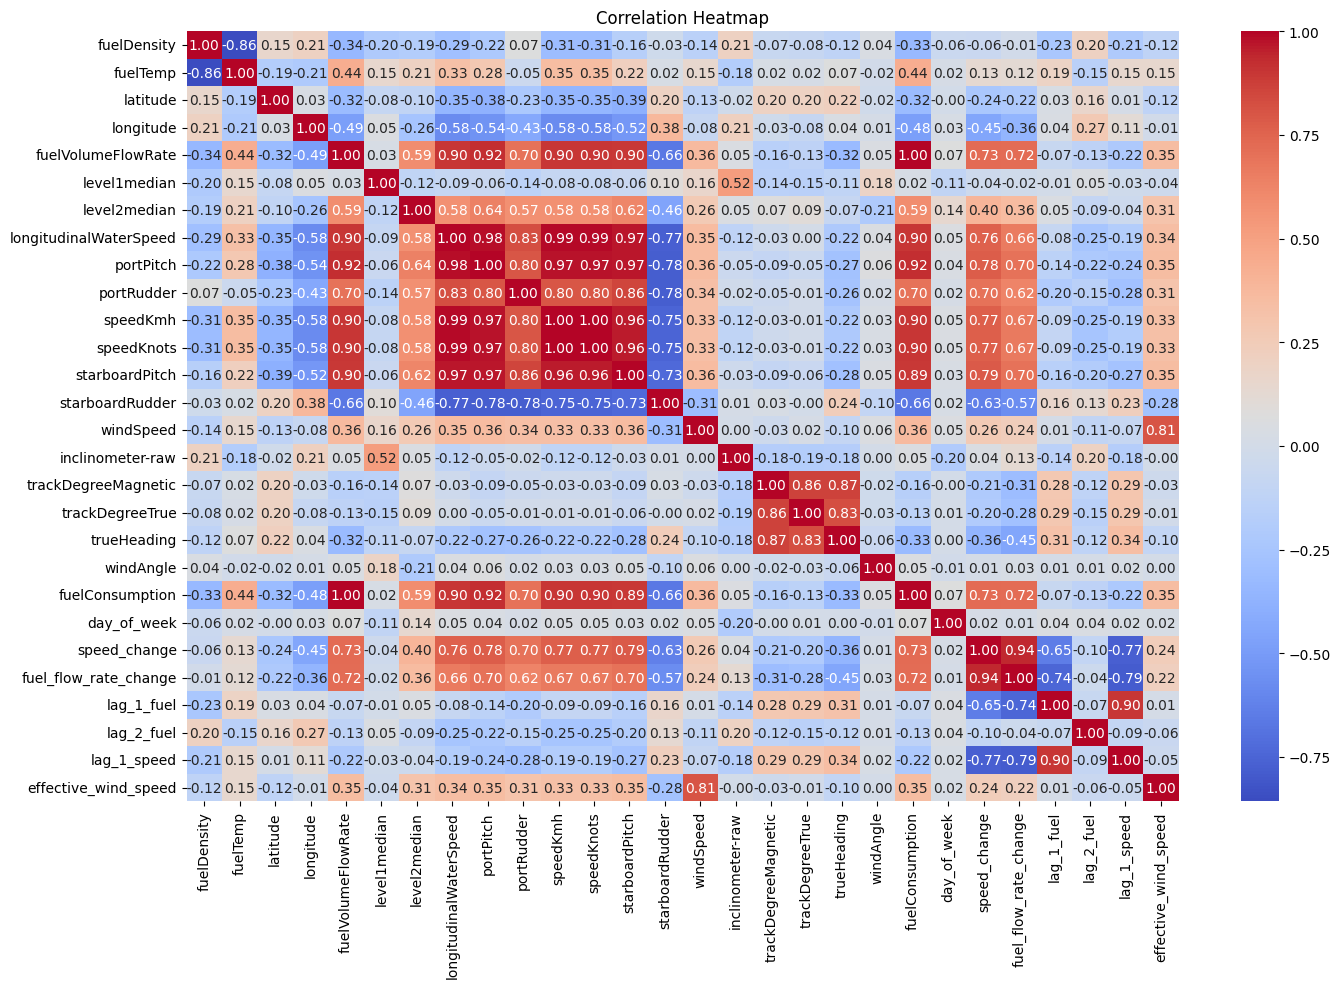

In [73]:
# Correlation heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [77]:
data = df.copy()

data.drop(columns=["speedKnots"], inplace=True) # speedKnots is highly correlated with speedKmh
data.drop(columns=["longitudinalWaterSpeed"], inplace=True) # it's highly correlated with speedKmh
data.drop(columns=["longitude", "latitude"], inplace=True) # they can be used to calculate distance, but we already have speed
data.drop(columns=["fuelVolumeFlowRate"], inplace=True) # it's too highly correlated with fuelConsumption

data.drop(columns=["windSpeed", "windAngle"], inplace=True) # effective_wind_speed is a better feature

# Dropping due to low correlation
data.drop(columns=["level1median"], inplace=True)
data.drop(columns=["day_of_week"], inplace=True)
data.drop(columns=["inclinometer-raw"], inplace=True)
data.drop(columns=["lag_1_fuel"], inplace=True)
data.drop(columns=["lag_2_fuel"], inplace=True)
data.drop(columns=["trackDegreeTrue"], inplace=True)
data.drop(columns=["trackDegreeMagnetic"], inplace=True)

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fuelDensity            688 non-null    float64
 1   fuelTemp               688 non-null    float64
 2   level2median           709 non-null    float64
 3   portPitch              710 non-null    float64
 4   portRudder             710 non-null    float64
 5   speedKmh               712 non-null    float64
 6   starboardPitch         710 non-null    float64
 7   starboardRudder        710 non-null    float64
 8   trueHeading            712 non-null    float64
 9   fuelConsumption        688 non-null    float64
 10  speed_change           711 non-null    float64
 11  fuel_flow_rate_change  686 non-null    float64
 12  lag_1_speed            711 non-null    float64
 13  effective_wind_speed   712 non-null    float64
dtypes: float64(14)
memory usage: 78.0 KB


In [80]:
data.isna().sum()

fuelDensity              24
fuelTemp                 24
level2median              3
portPitch                 2
portRudder                2
speedKmh                  0
starboardPitch            2
starboardRudder           2
trueHeading               0
fuelConsumption          24
speed_change              1
fuel_flow_rate_change    26
lag_1_speed               1
effective_wind_speed      0
dtype: int64

In [82]:
# NaN values are filled with the mean of the column
data.fillna(data.mean(), inplace=True)

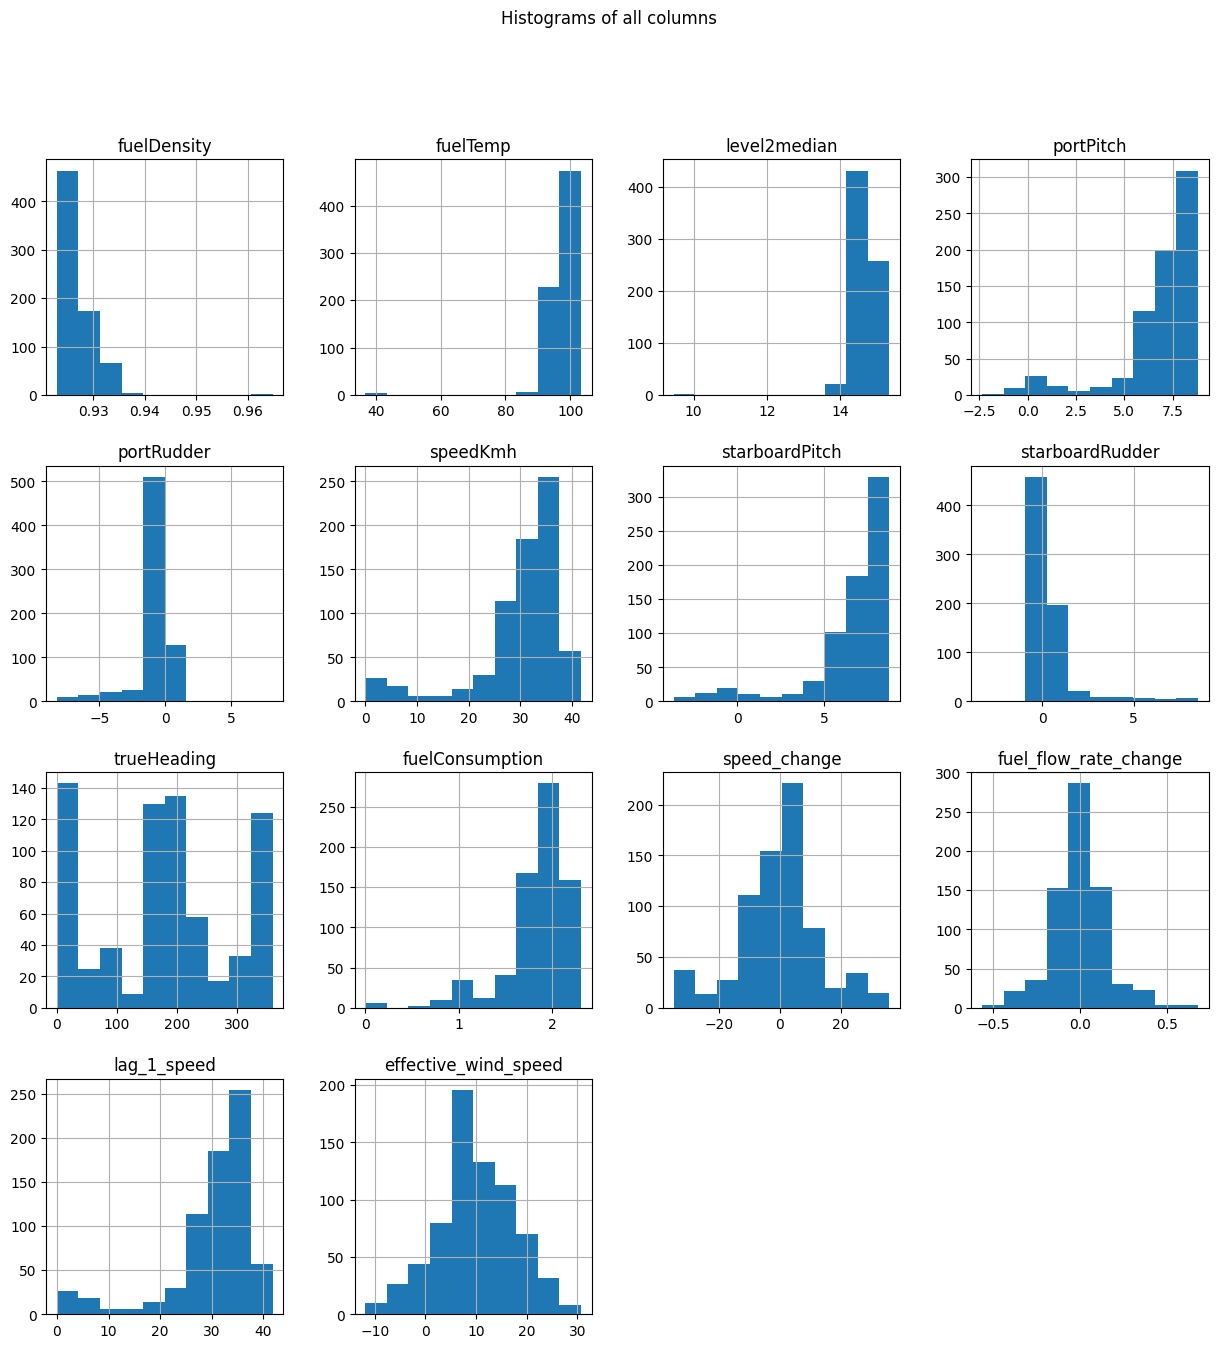

In [83]:
# Histograms of all columns
data.hist(figsize=(15, 15))
plt.suptitle("Histograms of all columns")
plt.show()

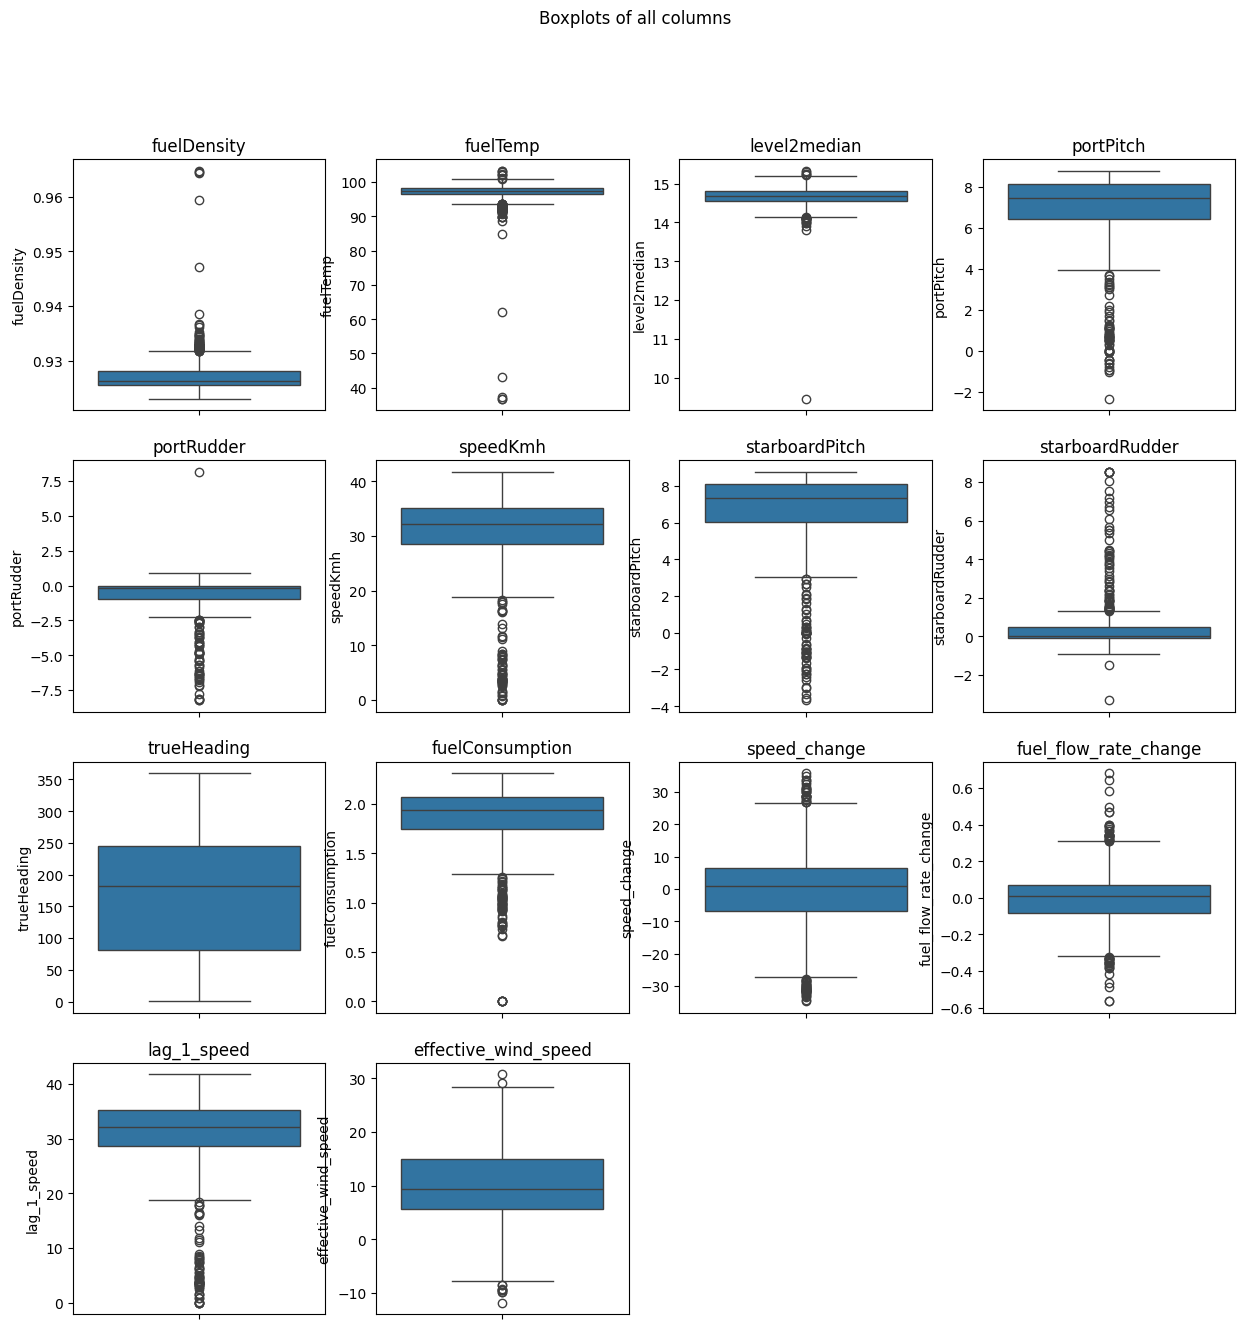

In [84]:
# Checking for outliers
plt.figure(figsize=(15, 15))
for i, column in enumerate(data.columns):
    plt.subplot(4, 4, i+1)
    sns.boxplot(data[column])
    plt.title(column)
plt.suptitle("Boxplots of all columns")
plt.show()

## Model training

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [109]:
def plot_results(n_estimators, metric, metric_name):
    plt.figure(figsize=(10, 6))
    plt.plot(n_estimators, metric, marker='o')
    plt.xlabel("Number of estimators")
    plt.ylabel(f"Metric {metric_name}")
    plt.title("Number of estimators vs. " + metric_name)
    plt.show()

In [86]:
target = data['fuelConsumption']
features = data.drop(columns=['fuelConsumption'])

print("Target shape:", target.shape)
print("Features shape:", features.shape)

Target shape: (712,)
Features shape: (712, 13)


In [ ]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [103]:
results = pd.DataFrame(columns=["Model", "R2 Score", "Mean Squared Error", "Mean Absolute Error", "Number of Estimators"])

Random Forest 100 - MAE: 0.0652993959914039, RMSE: 0.09422768252283713, R²: 0.9373554532102266
Random Forest 200 - MAE: 0.0642047536687406, RMSE: 0.09025011385130846, R²: 0.9425325709286406
Random Forest 300 - MAE: 0.06393049809730646, RMSE: 0.0904842659532331, R²: 0.9422339879230464
Random Forest 400 - MAE: 0.06361343352852039, RMSE: 0.09002545929836324, R²: 0.9428183157453286
Random Forest 500 - MAE: 0.06371847635695392, RMSE: 0.09015615509772255, R²: 0.9426521665069961


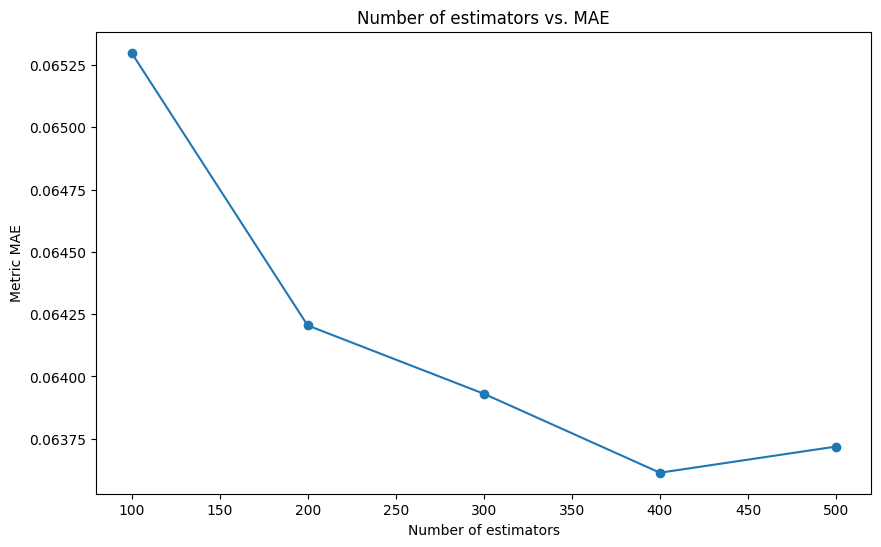

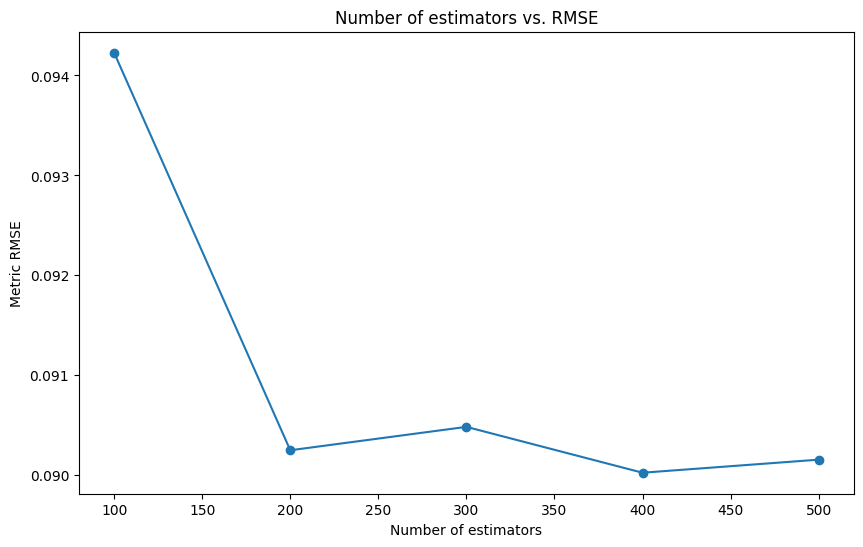

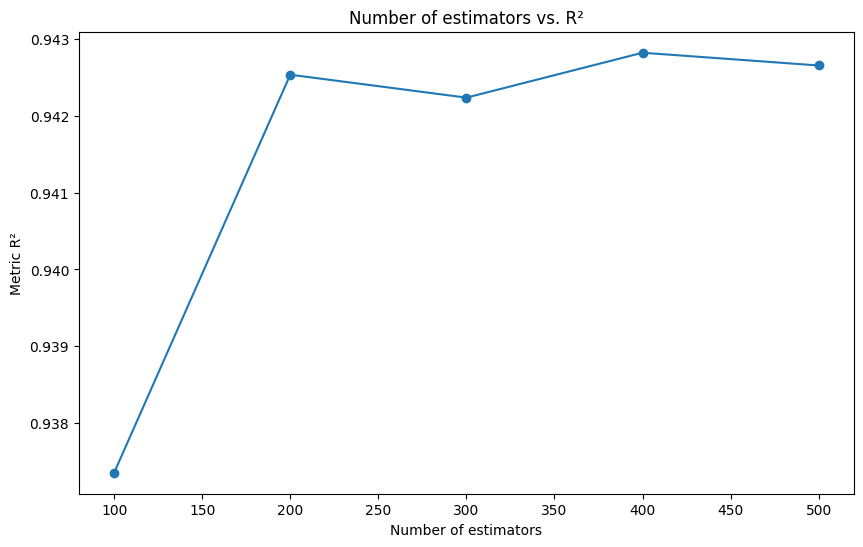

In [104]:
# Random Forest
n_estimators = [100, 200, 300, 400, 500]
mae = []
rmse = []
r2 = []

for n in n_estimators:
    rf_model = RandomForestRegressor(n_estimators=n, random_state=42)
    rf_model.fit(X_train, y_train)

    # Predictions
    rf_preds = rf_model.predict(X_test)

    # Evaluation
    rf_mae = mean_absolute_error(y_test, rf_preds)
    mae.append(rf_mae)

    rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
    rmse.append(rf_rmse)

    rf_r2 = r2_score(y_test, rf_preds)
    r2.append(rf_r2)

    results.loc[len(results)] = ["Random Forest", rf_r2, rf_rmse, rf_mae, n]

    print(f"Random Forest {n} - MAE: {rf_mae}, RMSE: {rf_rmse}, R²: {rf_r2}")

plot_results(n_estimators, mae, "MAE")
plot_results(n_estimators, rmse, "RMSE")
plot_results(n_estimators, r2, "R²")

XGBoost 100 - MAE: 0.055619177303965234, RMSE: 0.07521256421976803, R²: 0.9600876736321119
XGBoost 200 - MAE: 0.05561925867013426, RMSE: 0.07521259279142198, R²: 0.9600876433084179
XGBoost 300 - MAE: 0.055619290770641636, RMSE: 0.07521259836151903, R²: 0.960087637396756
XGBoost 400 - MAE: 0.05561931679638586, RMSE: 0.0752126028821318, R²: 0.9600876325989337
XGBoost 500 - MAE: 0.055619337900122835, RMSE: 0.07521260655206588, R²: 0.9600876287039545


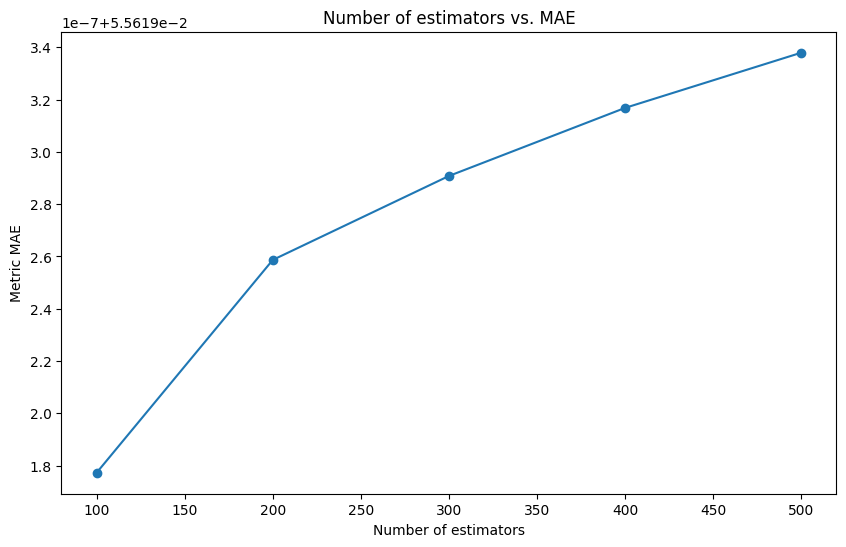

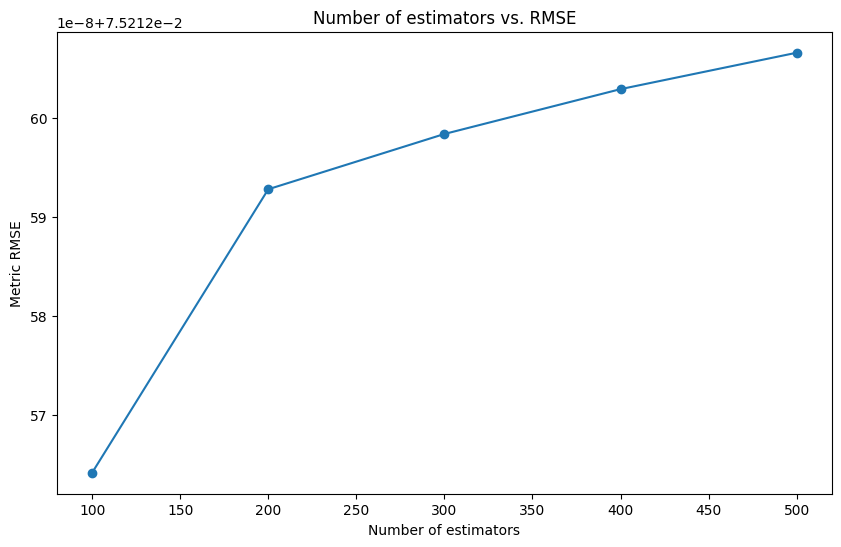

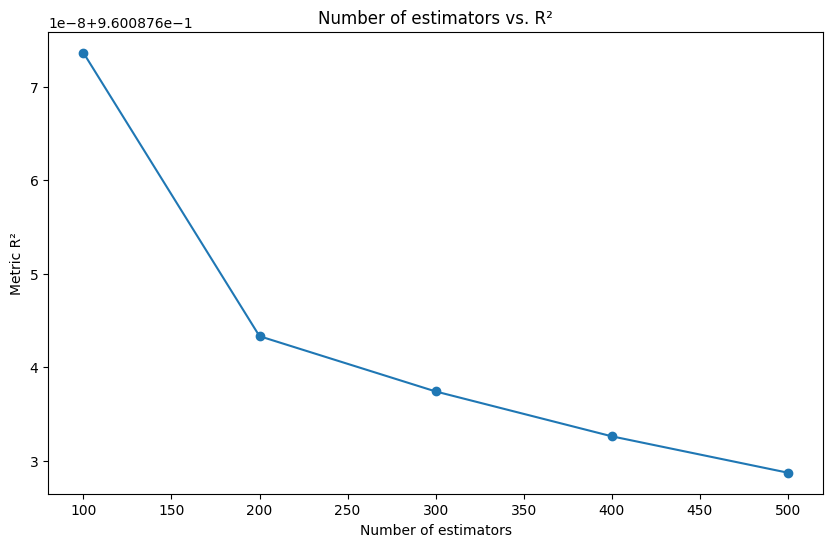

In [105]:
# XGBoost
n_estimators = [100, 200, 300, 400, 500]
mae = []
rmse = []
r2 = []

for n in n_estimators:
    xgb_model = XGBRegressor(n_estimators=n, random_state=42)
    xgb_model.fit(X_train, y_train)

    # Predictions
    preds = xgb_model.predict(X_test)

    # Evaluation
    xgb_mae = mean_absolute_error(y_test, preds)
    mae.append(xgb_mae)

    xgb_rmse = np.sqrt(mean_squared_error(y_test, preds))
    rmse.append(xgb_rmse)

    xgb_r2 = r2_score(y_test, preds)
    r2.append(xgb_r2)

    results.loc[len(results)] = ["XGBoost", xgb_r2, xgb_rmse, xgb_mae, n]

    print(f"XGBoost {n} - MAE: {xgb_mae}, RMSE: {xgb_rmse}, R²: {xgb_r2}")

plot_results(n_estimators, mae, "MAE")
plot_results(n_estimators, rmse, "RMSE")
plot_results(n_estimators, r2, "R²")

In [ ]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
lr_preds = lr_model.predict(X_test)

# Evaluation
lr_mae = mean_absolute_error(y_test, lr_preds)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_r2 = r2_score(y_test, lr_preds)

results.loc[len(results)] = ["Linear Regression", lr_r2, lr_rmse, lr_mae, 0]

print(f"Linear Regression - MAE: {lr_mae}, RMSE: {lr_rmse}, R²: {lr_r2}")

Linear Regression - MAE: 0.09202724379162222, RMSE: 0.13250282307360722, R²: 0.876127040314489


In [135]:
results.sort_values(by="R2 Score", ascending=False)

,Model,R2 Score,Mean Squared Error,Mean Absolute Error,Number of Estimators
5,XGBoost,0.960088,0.075213,0.055619,100
6,XGBoost,0.960088,0.075213,0.055619,200
7,XGBoost,0.960088,0.075213,0.055619,300
8,XGBoost,0.960088,0.075213,0.055619,400
9,XGBoost,0.960088,0.075213,0.055619,500
3,Random Forest,0.942818,0.090025,0.063613,400
4,Random Forest,0.942652,0.090156,0.063718,500
1,Random Forest,0.942533,0.090250,0.064205,200
2,Random Forest,0.942234,0.090484,0.063930,300
0,Random Forest,0.937355,0.094228,0.065299,100


## Visualization

In [127]:
def visualize_results(y_true, y_pred, model_name):
    plt.figure(figsize=(12, 6))
    
    # Compute absolute error for coloring
    error = np.abs(y_true - y_pred)
    norm = plt.Normalize(vmin=error.min(), vmax=error.max())
    
    # Scatter plot with gradient color based on error
    plt.scatter(y_true, y_pred, c=error, cmap='Reds', norm=norm, alpha=0.7, edgecolors='k')
    plt.colorbar(label="Absolute Error") 

    # Plot perfect prediction line
    min_val, max_val = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2)

    # Labels and title
    plt.xlabel("Actual Fuel Consumption")
    plt.ylabel("Predicted Fuel Consumption")
    plt.title(f"{model_name} Predictions")
    plt.show()

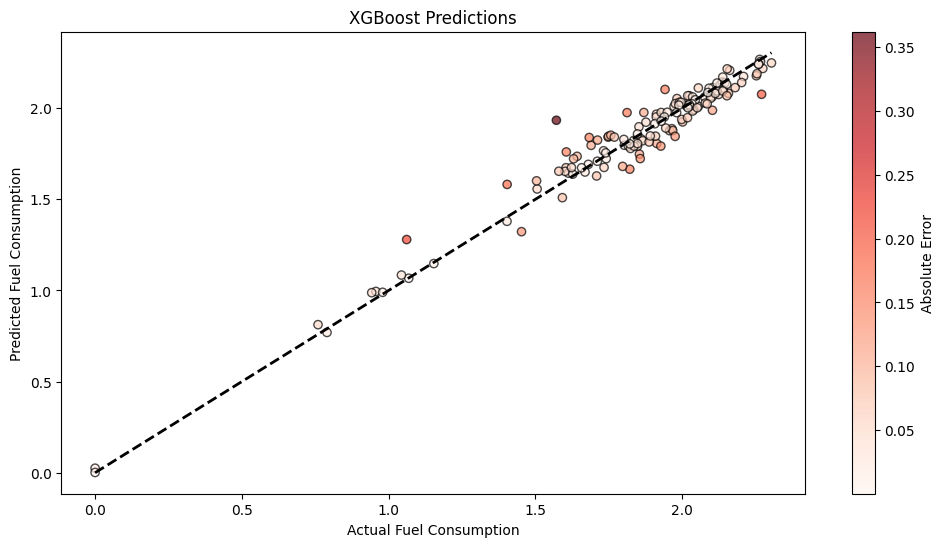

In [129]:
best_xgb_model = XGBRegressor(n_estimators=500, random_state=42)
best_xgb_model.fit(X_train, y_train)

best_xgb_preds = best_xgb_model.predict(X_test)

visualize_results(y_test, best_xgb_preds, "XGBoost")

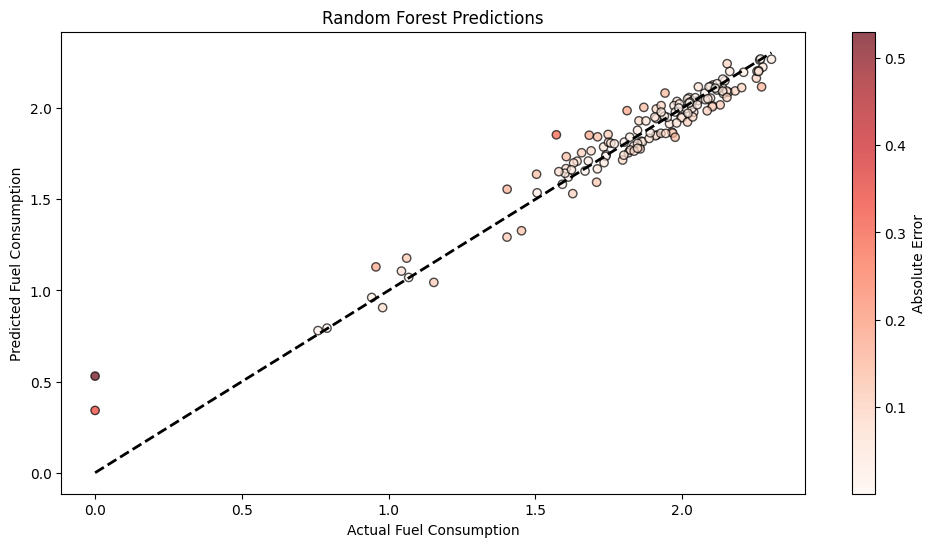

In [ ]:
best_rf_model = RandomForestRegressor(n_estimators=400, random_state=42)
best_rf_model.fit(X_train, y_train)

best_rf_preds = best_rf_model.predict(X_test)

visualize_results(y_test, best_rf_preds, "Random Forest")


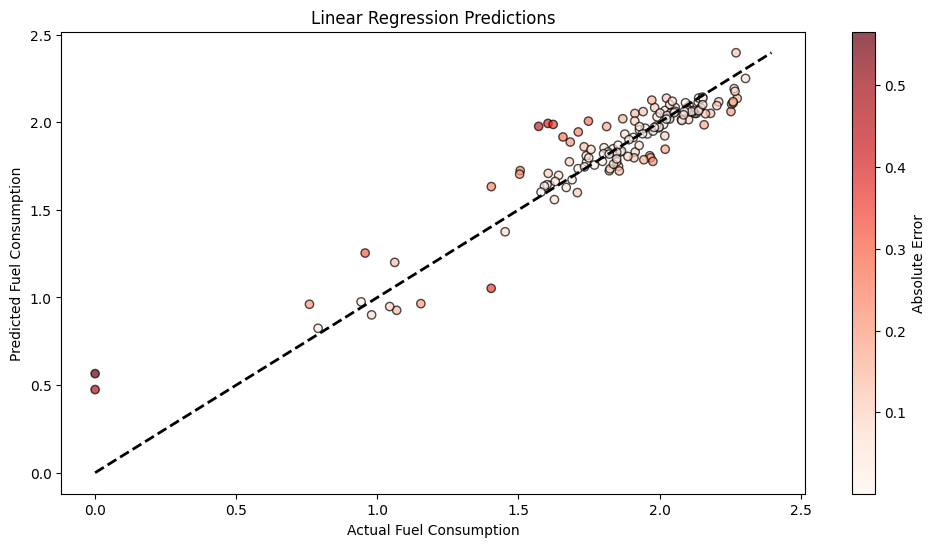

In [131]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

linear_preds = linear_model.predict(X_test)

visualize_results(y_test, linear_preds, "Linear Regression")

## Discussion

As it can be seen, XGBoost outperforms the other two models, regardless of the number of estimators used.
The difference in model performance comes from how each algorithm learns from the data. More on this will be disucssed in the report. 

Reasons why XGBoost is better than Random Forest in this case:
- Better handling of non-Linear relationships: fuel consumption depends on multiple factors like speed, wind speed, water conditions, etc. XGBoost can capture these complex interactions better than Random Forest.
- Gradient boosting reduces error: XGBoost iteratively corrects mistakes from previous trees, leading to better overall predictions.
- Feature importance optimization: XGBoost automatically identifies and prioritizes the most important features.